# interstellar extinction of dust

The examples from dustmaps documentation (https://dustmaps.readthedocs.io/en/latest/examples.html) are adapted for this notebook.

In the initial lines of codes, we will give a few examples on how to use the $E(B-V)$ map (for distance-independent dust correction, the 2nd task in the report) provided in Lenz, Hensley & Doré (2017). The application of these codes can be found after the codes for the first task (distance-dependent dust correction).


We distribute this map in the HEALPix format ([Górski et al. 2005](http://adsabs.harvard.edu/abs/2005ApJ...622..759G)), so [`healpy`](http://healpy.readthedocs.io/en/latest/) needs to be installed. Moreover, we use [`astropy`](http://astropy.org) for coordinate conversions.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # for high-resolution displays e.g. newer MacBooks

In [8]:
from __future__ import print_function
import numpy as np
import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
import warnings
warnings.filterwarnings('ignore')

In [9]:
ebv_map = hp.read_map('ebv_lhd.hpx.fits', verbose=False)

In [10]:
#hp.mollview(np.log10(ebv_map), title='', unit='log(E(B-V) [mag])')

# Setting basic healpix parameters
The HEALPix tessellation is fully defined by the nside of the map and the ordering.

In [13]:
nside = hp.get_nside(ebv_map)
npix = hp.nside2npix(nside)
ordering = 'ring'

# Reddening for a particular line of sight
We demonstrate how to use the $E(B-V)$ map and some basic python to extract reddenings along particular lines of sight.

In [14]:
def line_of_sight(lon, lat, coord='Galactic'):
    """
    Computes the reddening along a particular line of sight
    
    Input
    -----
    
    lon : float or 1D-array
        Input longitude in degree
    lat : float or 1D-array
        Input latitude in degree
    coord : 'Galactic' or 'ICRS', defaults to 'Galactic'
        Coordinate system in which lon and lat is evaluated
    
    Returns
    -------
    ebv_los : float or 1D-array
        Reddenings in mag along the line of sight.
        If the returned values are `np.nan`, then the map does not cover this part of the sky

    """
    if coord.lower() == 'icrs':
        s = SkyCoord(
            ra=lon * u.degree,
            dec=lat * u.degree,
            frame='icrs')
        s_gal = s.galactic
        glon = s_gal.l.value
        glat = s_gal.b.value
    else:
        glon = lon
        glat = lat
    
    # get pixel numbers
    pix = hp.ang2pix(nside, glon, glat, lonlat=True)
    
    # get reddening for these pixels
    ebv_los = ebv_map[pix]

    return ebv_los

In [15]:
ra, dec = [200, 110], [80, 65]
print('E(B-V) for R.A. = {ra}, Dec={dec}:'.format(ra=ra, dec=dec))
print('E(B-V):', line_of_sight(ra, dec, coord='icrs'))

E(B-V) for R.A. = [200, 110], Dec=[80, 65]:
E(B-V): [0.03016265        nan]


Note that `np.nan` means that this line of sight is not covered by the reddening map. All reddening values are in magnitudes.

In [16]:
glon, glat = [200, 110], [80, 65]
print('E(B-V) for l={glon}, b={glat}:'.format(glon=glon, glat=glat))
print('E(B-V):', line_of_sight(glon, glat, coord='galactic'))

E(B-V) for l=[200, 110], b=[80, 65]:
E(B-V): [0.01704503 0.00873742]


In [17]:
ebv2A_lambda_df = pd.read_table('conversions.txt', comment='#', index_col=0)

In [18]:
ebv2A_lambda_df.head(10)  #Reddening for different bandpasses

,lambda_eff,2.1,3.1,4.1,5.1
Bandpass,,,,,
Landolt U,3508.2,5.614,4.334,3.773,3.460
Landolt B,4329.0,4.355,3.626,3.290,3.096
Landolt V,5421.7,2.953,2.742,2.645,2.589
Landolt R,6427.8,2.124,2.169,2.189,2.201
Landolt I,8048.4,1.410,1.505,1.548,1.573
CTIO U,3733.9,5.170,4.107,3.628,3.355
CTIO B,4308.9,4.382,3.641,3.300,3.104
CTIO V,5516.6,2.857,2.682,2.600,2.553
CTIO R,6520.2,2.055,2.119,2.149,2.166


In [19]:
def ebv2A_lambda(ebv, bandpass):
    """
    Converts reddening to extinction in a given
    bandpass, following the values of Schlafy & Finkbeiner (2011, Table 6)
    
    Input
    -----
    ebv : float or ndarray
        Input reddening value or vector
    bandpass : str
        Bandpass for which the extinction is computed. Must be
        part of Schlafly & Finkbeiner (2011, Table 6)
        
    Returns
    -------
    A_lambda : float or ndarray
        Extinction in the selected band, has same shape as input ebv
    
    """

    factor = ebv2A_lambda_df['3.1'][bandpass]
    A_lambda = ebv * factor

    return A_lambda

In [20]:
# 50 mmag
ebv2A_lambda(0.05, 'Landolt V')

0.1371

In [21]:
# The entire E(B-V) map
A_v_map = ebv2A_lambda(ebv_map, 'Landolt V')

In [22]:
#hp.mollview(np.log10(A_v_map), title='', unit='A_v [mag]')

In [30]:
from dustmaps.sfd import SFDQuery
from dustmaps.planck import PlanckQuery
from dustmaps.bayestar import BayestarQuery
from astropy.coordinates import SkyCoord
from astropy import units as u

coords = SkyCoord('12h30m25.3s','15d15m58.1s', frame='icrs')
planck = PlanckQuery()
ebv = planck(coords)

print('E(B-V) = {:.3f} mag'.format(ebv))

E(B-V) = 0.035 mag


In [43]:
import astropy.units as units
d=np.arange(100,10**3,10)
coords = SkyCoord(180.*units.deg, 0.*units.deg,
                  distance=d*units.pc, frame='galactic')
ebv = bayestar(coords, mode='median')

print(ebv)

[0.         0.         0.         0.         0.         0.0004365
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01763652
 0.03658964 0.04       0.041697   0.05308935 0.06       0.06
 0.06259157 0.06762722 0.075042   0.08456138 0.09       0.09
 0.09       0.09       0.09       0.09338738 0.09738106 0.09999999
 0.09999999 0.09999999 0.09999999 0.09999999 0.09999999 0.09999999
 0.09999999 0.09999999 0.1029575  0.10614508 0.10927521 0.11939976
 0.13148479 0.14336321 0.14999999 0.14999999 0.14999999 0.14999999
 0.15247199 0.15516533 0.15781757 0.16       0.16       0.16
 0.16       0.16       0.16       0.16       0.16       0.16
 0.16       0.16       0.16       0.16       0.16123599 0.163394
 0.16552554 0.16763124 0.16971171 0.17530271 0.18139814 0.1874231
 0.1933792  0.199268   0.203394   0.2072331  0.21103026 0.21478635
 0.21850228 0.22       0.22       0.22       0.22       0.22      ]


As shown above, the color excess is indeed larger as the distance increases.

In [40]:
d = np.arange(10,80,0.5)
l0, b0 = (100., 30.) #longitude,latitude
l, b = np.meshgrid(l, b)
coords = SkyCoord(l0*u.deg, b0*u.deg, distance= d*u.kpc, frame='galactic')
bayestar = BayestarQuery(max_samples=1)
Av_bayestar = 2.742 * bayestar(coords)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 17.733 s
  pix_info:   0.385 s
   samples:   4.058 s
      best:   4.045 s
       nan:   0.025 s
      sort:   9.070 s
       idx:   0.150 s


In [1]:
#print(Av_bayestar) # see distance dependent effect of A_V in appendix A 

In [35]:
l0, b0 = (100., 30.) # set up boundaries of the bayestar map slice we work sith 
l = np.arange(l0 - 5., l0 + 5., 0.05) #longitude
b = np.arange(b0 - 5., b0 + 5., 0.05)#latitude
l, b = np.meshgrid(l, b)
coords = SkyCoord(l*u.deg, b*u.deg,
                  distance=100.*u.kpc, frame='galactic')


In [33]:
bayestar = BayestarQuery(max_samples=1)
Av_bayestar = 2.742 * bayestar(coords)

Text(6, -10, 'D')

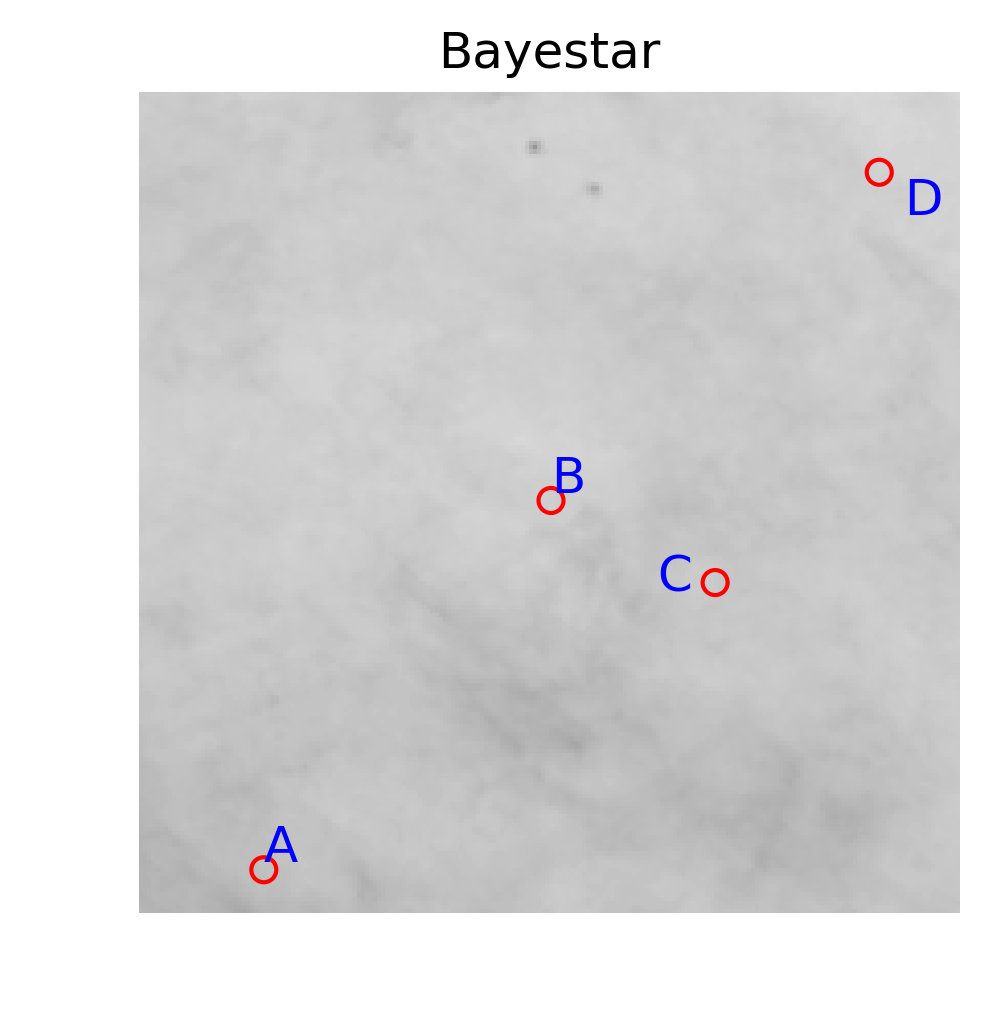

In [38]:
fig = plt.figure(figsize=(12,4), dpi=150)
dat = np.array([[30,100,140,180],
                [10,100,80,180]])


for k,(Av,title) in enumerate([(Av_bayestar, 'Bayestar')]):
    ax = fig.add_subplot(1,3,k+1)
    ax.imshow(
        np.sqrt(Av_planck)[::, ::-1],
        vmin=0.,
        vmax=2.,
        origin='lower',
        interpolation='nearest',
        cmap='binary',
        aspect='equal'
    )
    ax.axis('off')
    ax.set_title(title)


plt.scatter(dat[0], dat[1],  facecolors='none', edgecolors='r') # Uncomment if you want green circles
ax.annotate('A', xy=(30,10), xytext=(0, 2),
            textcoords='offset points',
            color='b', size='large'
)
ax.annotate('B', xy=(100,100), xytext=(0, 2),
            textcoords='offset points',
            color='b', size='large'
)
ax.annotate('C', xy=(140,80), xytext=(-14, -2),
            textcoords='offset points',
            color='b', size='large'
)
ax.annotate('D', xy=(180,180), xytext=(6, -10),
            textcoords='offset points',
            color='b', size='large'
)


The Hubble Space Telescope (HST) have a "limiting magnitude" $+31.5$ while  James Webb Space Telescope (JWST) has limiting magnitude of $+34$ (from the midterm).Using these known parameters, we will verify whether the region that we have for our reddening analysis can be viewed by these two telescope, given their limiting magnitude determines the  faintest thing they can see. 
(In reality this is not an entirely fair comparison because HST and JWST observe at different wavelengths and are good at different types of science. We also assume that both telescopes locate at some fixed point about the earth, which is not a real scenario as JWST orbit the sun while HST orbits the earth. 

$m_0-M = 5 \log_{10} D_L -5$, where $D_L$ is measured in pc, where $m_0$ is the apparent magnitude with no extinction correction.With extinction, we have $A = m - m_0$, or $m_0 = m - A$. Therefore, we have
$m-M = 5 \log_{10} d -5 + A$ with dust (extinction)

In [26]:
JWST_mag_lim = 34
HST_mag_lim = 31.5
d = 10**5 #100kpc
JWST_abs_mags = JWST_mag_lim - 5. * np.log10(d/1000) + 5 - Av_bayestar
HST_abs_mags = HST_mag_lim - 5. * np.log10(d/1000) + 5 - Av_bayestar
np.max(JWST_abs_mags),np.max(HST_abs_mags)

(29.0, 26.5)

The faintest thing (at a distance of 100 kpc from us) that the two telescopes can observe are qualified by the absolute magnitude of  29 (JWST) and 26.5 (HST).

In [27]:
from astropy.cosmology import Planck15 # Use planck15 data
l0, b0 = (100., 30.) # ra of 8hr
l = np.arange(l0 - 5., l0 + 5., 0.05)
b = np.arange(b0 - 5., b0 + 5., 0.05)
l, b = np.meshgrid(l, b)
JWST_mag_lim = 34
HST_mag_lim = 31.5

def mag_dust(dist, label,l0,b0):  #input value, input value type (redshift/pure distance), longitude,latitude
    if (label=='z'): # input is redshift
        luminosity_distance = Planck15.luminosity_distance(dist)*10**6# redshift luminosity distance in Mpc
    elif (label=='d'):# input is distance
        luminosity_distance = dist*u.pc # input distance with unit of pc
    coords = SkyCoord((l0)*u.deg, (b0)*u.deg,
                  distance=luminosity_distance, frame='galactic')

    Av_bayestar = 2.742 * bayestar(coords)
    JWST_mags_dust = JWST_mag_lim - 5. * np.log10(luminosity_distance.value) + 5 - Av_bayestar
    HST_mags_dust = HST_mag_lim - 5. * np.log10(luminosity_distance.value) + 5 - Av_bayestar
    
    return JWST_mags_dust,HST_mags_dust,Av_bayestar

def mag_without_dust(dist, label,l0,b0):  
    if (label=='z'):# input is redshift
        luminosity_distance = Planck15.luminosity_distance(dist)*10**6# redshift
    elif (label=='d'):# input distance with unit of pc
        luminosity_distance = dist*u.kpc
        
    coords = SkyCoord((l0)*u.deg, (b0)*u.deg,
                  distance=luminosity_distance, frame='galactic')

    JWST_mags = JWST_mag_lim - 5. * np.log10(luminosity_distance.value) + 5
    HST_mags = HST_mag_lim - 5. * np.log10(luminosity_distance.value) +5
    return JWST_mags,HST_mags    


In [28]:
dat = np.array([[30,100,140,180],
                [10,100,80,180]])
long,lat = dat[0],dat[1] # x value is longitude, y value latitude
coord_list = []
for i in range(len(long)):
    coord_list.append(coords[lat[i]][long[i]]) # coords first dimension in latitude, second in longitude 
quad_coord = coord_list
quad_coord

[<SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
     (96.5, 25.5, 100.)>,
 <SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
     (100., 30., 100.)>,
 <SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
     (102., 29., 100.)>,
 <SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
     (104., 34., 100.)>]

In [29]:
JWST_mags_dust,HST_mags_dust,Av_bayestar = [],[],[]
JWST_mags,HST_mags=[],[]
for i in range(len(coord_list)):
    output_dust = mag_dust(10**5,'d',coord_list[i].l.value,coord_list[i].b.value)
    JWST_mags_dust.append(output_dust[0])
    HST_mags_dust.append(output_dust[1])
    Av_bayestar.append(output_dust[2])
    no_dust = mag_without_dust(10**5,'d',coord_list[i].l.value,coord_list[i].b.value)
    JWST_mags.append(no_dust[0])
    HST_mags.append(no_dust[1])
print("The magnitude of the limiting behavior of JWST and HST after the dust correction, and the extinction magnitude Av, observed when targeting at point A with 50kpc distance, are given in the three arrays.")
np.round(JWST_mags_dust,4),np.round(HST_mags_dust,4),np.round(Av_bayestar,4)  

The magnitude of the limiting behavior of JWST and HST after the dust correction, and the extinction magnitude Av, observed when targeting at point A with 50kpc distance, are given in the three arrays.


(array([13.7806, 13.9177, 13.8355, 13.8629]),
 array([11.2806, 11.4177, 11.3355, 11.3629]),
 array([0.2194, 0.0823, 0.1645, 0.1371]))

In [30]:
mag_dust(500,'d',coord_list[0].l.value,coord_list[0].b.value)

(25.3680499864917, 22.8680499864917, 0.1370999918282032)

In [31]:
JWST_mags_dust,HST_mags_dust,Av_bayestar = [],[],[]
JWST_mags,HST_mags=[],[]
for i in range(len(coord_list)):
    output_dust = mag_dust(0.01,'z',coord_list[i].l.value,coord_list[i].b.value)
    JWST_mags_dust.append(output_dust[0])
    HST_mags_dust.append(output_dust[1])
    Av_bayestar.append(output_dust[2])
    no_dust = mag_without_dust(0.01,'z',coord_list[i].l.value,coord_list[i].b.value)
    JWST_mags.append(no_dust[0])
    HST_mags.append(no_dust[1])
print("The magnitude of the limiting behavior of JWST and HST after the dust correction and the extinction magnitude Av, observed when targeting at point A with z=0.01, are given in the three arrays.")
np.round(JWST_mags_dust,4),np.round(HST_mags_dust,4),np.round(Av_bayestar,4)  

The magnitude of the limiting behavior of JWST and HST after the dust correction and the extinction magnitude Av, observed when targeting at point A with z=0.01, are given in the three arrays.


(array([0.5342, 0.6713, 0.589 , 0.6165]),
 array([-1.9658, -1.8287, -1.911 , -1.8835]),
 array([0.2194, 0.0823, 0.1645, 0.1371]))

In [32]:
dist=np.arange(100,10**6,100)

JWST_mags_dust,HST_mags_dust,Av_bayestar = [],[],[]
JWST_mags,HST_mags=[],[]
for i in range(len(coord_list)):
    output_dust = mag_dust(dist,'d',coord_list[i].l.value,coord_list[i].b.value)
    JWST_mags_dust.append(output_dust[0])
    HST_mags_dust.append(output_dust[1])
    Av_bayestar.append(output_dust[2])
    no_dust = mag_without_dust(dist,'d',coord_list[i].l.value,coord_list[i].b.value)
    JWST_mags.append(no_dust[0])
    HST_mags.append(no_dust[1])
JWST_mags[0],JWST_mags_dust[0] # magnitudes (without correction) for the point A 

(array([29.        , 27.49485002, 26.61439373, ...,  9.00065154,
         9.00043434,  9.00021716]),
 array([29.        , 27.49485002, 26.58464713, ...,  8.78129153,
         8.78107433,  8.78085715]))

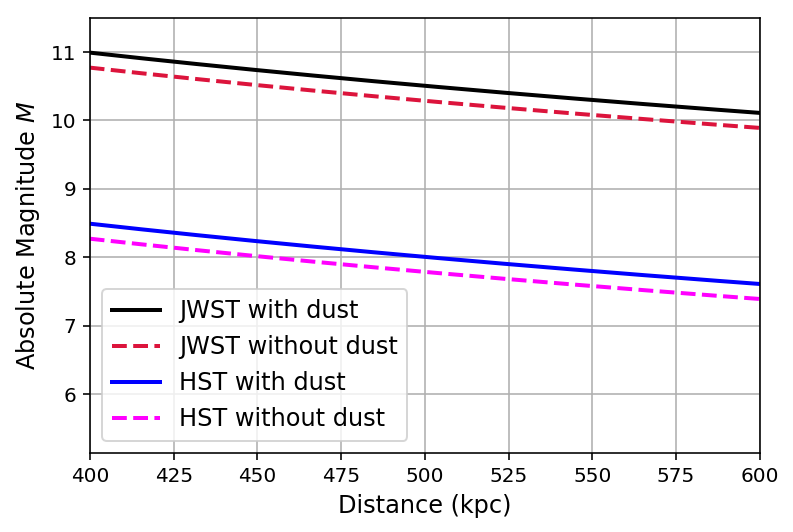

In [33]:
f, ax = plt.subplots(figsize=(6,4))
ax.plot(dist/1000, JWST_mags[0], lw=2, color='black', label='JWST with dust')
ax.plot(dist/1000, JWST_mags_dust[0], lw=2, color='crimson', ls='--', label='JWST without dust')
ax.plot(dist/1000, HST_mags[0], lw=2, color='blue', label='HST with dust')
ax.plot(dist/1000, HST_mags_dust[0], lw=2, color='magenta', ls='--', label='HST without dust')
ax.set_xlabel(r'Distance (kpc)',fontsize=12)
ax.set_ylabel(r'Absolute Magnitude $M$',fontsize=12)
ax.set_xlim(left=400, right=600)
ax.set_ylim(bottom = None, top = 11.5)
plt.legend(fontsize = 12)
plt.grid() #at point A coord_list[0]

In [34]:
Planck15.luminosity_distance(0.05) #z=0.01 with 44.596Mpc

<Quantity 229.62772697 Mpc>

In [35]:
redshift=np.arange(0.01,0.06,0.0001)

JWST_mags_dust,HST_mags_dust,Av_bayestar = [],[],[]
JWST_mags,HST_mags=[],[]
for i in range(len(coord_list)):
    output_dust = mag_dust(redshift,'z',coord_list[i].l.value,coord_list[i].b.value)
    JWST_mags_dust.append(output_dust[0])
    HST_mags_dust.append(output_dust[1])
    Av_bayestar.append(output_dust[2])
    no_dust = mag_without_dust(redshift,'z',coord_list[i].l.value,coord_list[i].b.value)
    JWST_mags.append(no_dust[0])
    HST_mags.append(no_dust[1])


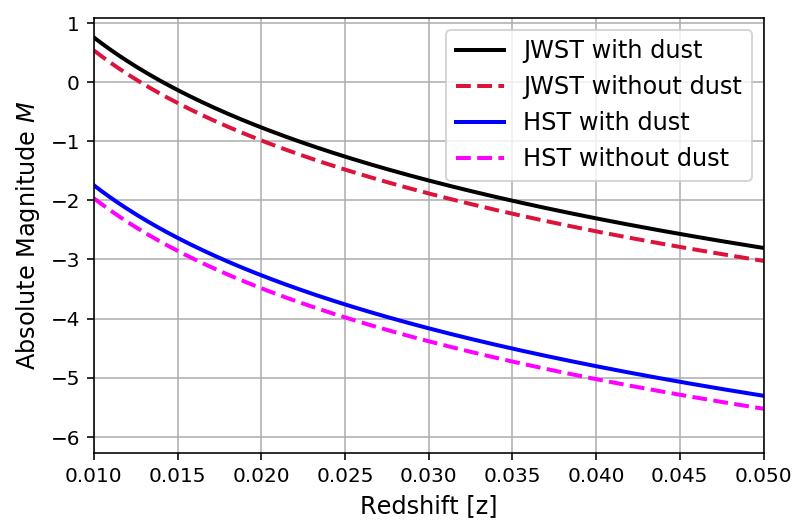

In [36]:
f, ax = plt.subplots(figsize=(6,4))
ax.plot(redshift, JWST_mags[0], lw=2, color='black', label='JWST with dust')
ax.plot(redshift, JWST_mags_dust[0], lw=2, color='crimson', ls='--', label='JWST without dust')
ax.plot(redshift, HST_mags[0], lw=2, color='blue', label='HST with dust')
ax.plot(redshift, HST_mags_dust[0], lw=2, color='magenta', ls='--', label='HST without dust')
ax.set_xlabel(r'Redshift [z]',fontsize=12)
ax.set_ylabel(r'Absolute Magnitude $M$',fontsize=12)
ax.set_xlim(left=0.01, right=0.05)
#ax.set_xlim()
#ax.set_ylim([0,1.3])
plt.legend(fontsize=12)
plt.grid() #at point A coord_list[0]

In [29]:
quad_coord

[<SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
     (96.5, 25.5, 100.)>,
 <SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
     (100., 30., 100.)>,
 <SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
     (102., 29., 100.)>,
 <SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
     (104., 34., 100.)>]

In [33]:
glon, glat = [],[]
for i in range(4):
    glon.append(np.round(quad_coord[i].l.value))
    glat.append(np.round(quad_coord[i].b.value))

In [35]:
print('E(B-V) for l={glon}, b={glat}:'.format(glon=glon, glat=glat))
print('E(B-V):', line_of_sight(glon, glat, coord='galactic'))

E(B-V) for l=[96.0, 100.0, 102.0, 104.0], b=[26.0, 30.0, 29.0, 34.0]:
E(B-V): [       nan 0.04041761        nan 0.04535962]


"Nan" means that points A and C are not covered by the reddening map.

In [38]:
ebv2A_lambda(0.04041761, 'Landolt V')# point B

0.11082508662

In [42]:
ebv2A_lambda(0.04535962, 'Landolt V')# point D

0.12437607804